# 합성곱 신경망을 사용한 이미지 분류

In [15]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [16]:
## 패션 MNIST 데이터 불러오기

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)


## 합성곱 신경망 만들기

In [17]:
model = keras.Sequential()

# 32개 필터, 필터의 크기는 3
# 커널의 크기는 알아서 정해진다
# 첫번째 층에는 input_shape를 넣어준다. 입력 배열의 크기
# 특성맵은 28*28*32 (사진크기*필터개수)로 정해지게 된다.
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

# MaxPooling을 많이 쓴다
model.add(keras.layers.MaxPooling2D(2))
# 이 단계를 지나서 만들어지는 크기는 14*14*32 (풀링으로 인해 줄어든 차원 * 필터개수)

# kernel_size=3 해도 무방
# 3크기의 필터 사용
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
# 여기까지 하면 7*7*64

# 일렬로 펼침
model.add(keras.layers.Flatten())
# 그 후에는 Dense층으로
model.add(keras.layers.Dense(100, activation='relu'))
# 과대적합을 막기 위한 40%의 Dropout
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

# 모델 요약
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

## 좀 더 자세히 보기

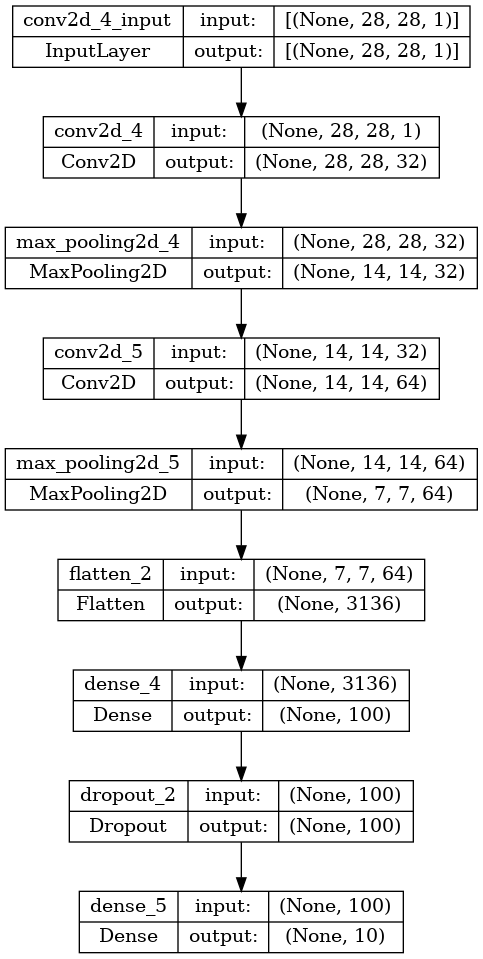

In [18]:
keras.utils.plot_model(model, show_shapes=True)

# keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

## 모델 컴파일과 훈련

Epoch 1/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5403 - accuracy: 0.8089 - val_loss: 0.3371 - val_accuracy: 0.8762
Epoch 2/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3608 - accuracy: 0.8714 - val_loss: 0.2832 - val_accuracy: 0.8940
Epoch 3/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3067 - accuracy: 0.8895 - val_loss: 0.2569 - val_accuracy: 0.9051
Epoch 4/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2754 - accuracy: 0.9015 - val_loss: 0.2395 - val_accuracy: 0.9125
Epoch 5/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2453 - accuracy: 0.9108 - val_loss: 0.2574 - val_accuracy: 0.9078
Epoch 6/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2275 - accuracy: 0.9157 - val_loss: 0.2235 - val_accuracy: 0.9184
Epoch 7/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2117 - accuracy: 0.9222 - val_loss: 0.2194 - val_accuracy:

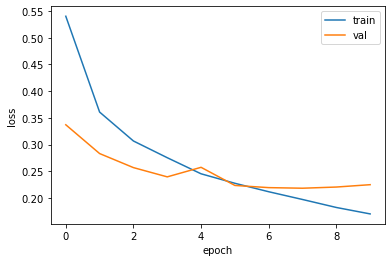

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# 체크포인트 콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
# 조기종료 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 평가

375/375 [==============================] - 0s 927us/step - loss: 0.2183 - accuracy: 0.9217


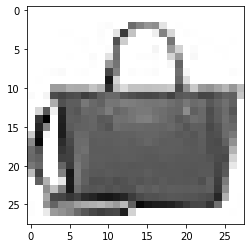

In [20]:
model.evaluate(val_scaled, val_target)

plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

## 예측

In [21]:
preds = model.predict(val_scaled[0:1])
print(preds)
# 9번째를 제외한 다른 것들은 0에 가까운 수가 나온다.
# 9번째가 가방이다.

1/1 [==============================] - 0s 41ms/step
[[9.83498425e-15 1.14464634e-26 5.97949550e-18 2.83537372e-18
  1.19523284e-15 2.76382695e-16 1.79496009e-17 3.71620205e-15
  1.00000000e+00 3.87297080e-17]]


## 좀 더 보기 쉽게

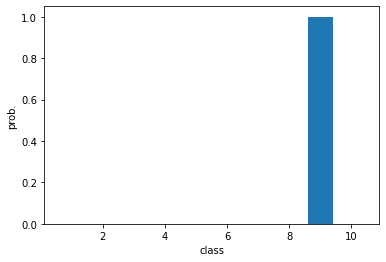

가방
313/313 [==============================] - 0s 1ms/step - loss: 0.2363 - accuracy: 0.9164


[0.2363009750843048, 0.9164000153541565]

In [22]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

import numpy as np
print(classes[np.argmax(preds)])

test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

model.evaluate(test_scaled, test_target)

## 테스트 세트 점수

In [23]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 0s 1ms/step - loss: 0.2363 - accuracy: 0.9164


[0.2363009750843048, 0.9164000153541565]